# Continuous LQR
## Analytic problem (17-12)


In [2]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

import random
from scipy.integrate import odeint,solve_ivp
from scipy.interpolate import interp1d

from sympy import Matrix, init_printing
init_printing()

Running Python: 3.8.16


### Problem Definition

In [3]:
n = 1                                 # state dim
dt = 1e-4                             # integration delta t
Tf = np.exp(1)/5                               # final time  
Npts = round(Tf/dt)                   # number of integration pts    
t = np.linspace(0,Tf,Npts)
tau = Tf - t                          # backwards time for P matrix

A = np.array([np.pi])      # dynamics matrix
B = np.array([np.sqrt(2)])              # input matrix
RN = np.array([np.sqrt(3)/10])        # terminal state cost 
P = np.zeros((n,n,Npts))              # cost to go matrix
Rxx = np.array(1/9.)      # state cost in LQR
Ruu = np.array(0.5)                     # control cost in LQR

### Integration of $P(t)$

In [4]:
def doty(y, t, A, B, Rxx, Ruu):
    n = 1
    P = y.reshape(n,n)
    P = (P + P.T)/2                   # make sure that P is symmetric
    dotP = P@A + A.T@P + Rxx - np.multiply(P@B,np.linalg.inv(np.atleast_2d(Ruu)))@B.T@P
    return dotP.reshape(n**2,)
    
# integrate P forward in tau (backward in t) from RN
sol = odeint(doty, RN, t, rtol=1e-9, args=(A, B, Rxx, Ruu))
K_ss, P_ss = lqr(A,B,Rxx,Ruu)

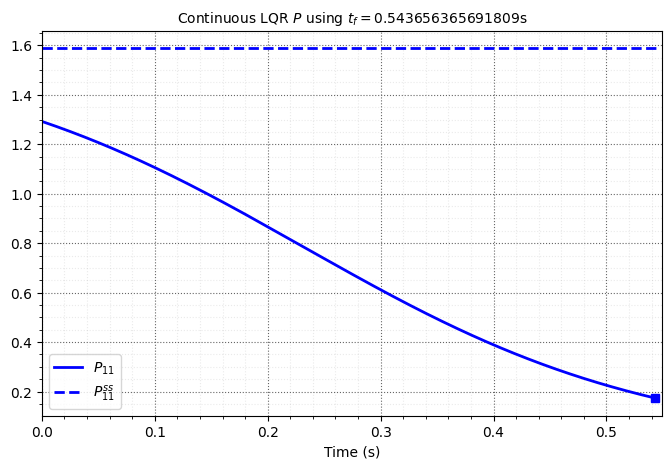

In [14]:
plt.figure(2,figsize=(8,5))
plt.plot(tau, sol[:, 0], 'b', label=r'$P_{11}$')
plt.plot([0,Tf],[P_ss[0],P_ss[0]],'b--',label=r'$P^{ss}_{11}$')
plt.plot(0.999*Tf,RN[0],'bs')
plt.legend()
plt.title('Continuous LQR $P$ using $t_f=$'+str(Tf)+'s')
plt.xlim([0,Tf*1.01])
plt.xlabel(r'Time (s)')
plt.savefig("figs/CLQR_ex1_1.png")
nicegrid()
plt.show()

### Steady State $P$

In [15]:
print('P steady state value')
display(Matrix(np.round(P_ss,4)))

print('compare to P Numerical')
display(Matrix(np.round(sol[-1,:].reshape(n,n),4)))

print(r'Computed Steady State Gain K')
display(Matrix(np.round(K_ss,4)))

K = np.zeros((1,Npts))
for II in np.arange(Npts):
    K[:,Npts-1-II] = np.linalg.inv(np.atleast_2d(Ruu))@B.T@sol[II,:].reshape(n,n)

print(f'Compare to Numerical Gain K = {K[0,0]:.4f}')


P steady state value


compare to P Numerical


Computed Steady State Gain K


Compare to Numerical Gain K = 3.6554


### Gains $K(t)$

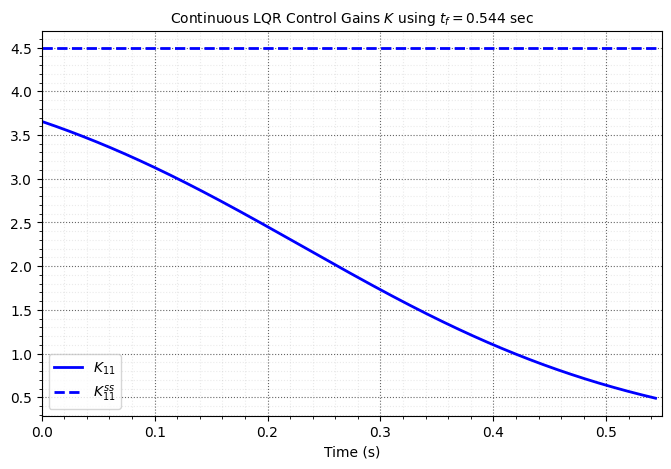

In [16]:
plt.figure(3,figsize=(8,5))
plt.plot(t[0:],K[0,:], 'b', label=r'$K_{11}$')
plt.plot([0,Tf],[K_ss[0],K_ss[0]],'b--',label=r'$K^{ss}_{11}$')
plt.legend()
plt.xlim([0,Tf*1.01])
plt.title('Continuous LQR Control Gains $K$ using $t_f=$'+str(np.round(Tf,3))+' sec')
plt.xlabel(r'Time (s)')
nicegrid()
plt.savefig("figs/CLQR_ex1_2.png")
plt.show()

## Forward Simulation of state response with cts LQR 

In [17]:
x0 = np.array([1])    # state initial condition
X = np.zeros((1,Npts))
X_ss = np.zeros((n,Npts))
U = np.zeros((1,Npts-1))
U_ss = np.zeros((1,Npts-1))
X[0,0] = x0
X_ss[0,0] = x0

Acl_ss = A - B@K_ss

for k in np.arange(Npts-1):
    Acl = A - B*K[0,k]
    U[0,k] = K[0,k]*X[0,k]
    U_ss[0,k] = K_ss*X_ss[0,k]
    X[0,k+1] = X[0,k] + dt*Acl*X[0,k]
    X_ss[0,k+1] = X_ss[0,k] + dt*Acl_ss*X_ss[0,k]

In [18]:
def Compute_cost(Npts,Tf,dt,X,U,H,Rxx,Ruu):
    t_int = np.linspace(0,Tf-dt,Npts-1)
    U_int = interp1d(x = t_int, y = U, kind='zero')
    X0_int = interp1d(x = t_int, y = X[0,:-1], kind='zero')

    Jtf = 0.5*X[0,-1].T*H*X[0,-1]

    def Jderiv(t,T,X0,U,Rxx,Ruu):
        x = np.array([X0(t)])
        u = np.array([U(t)])
        deriv = np.dot(x.T,Rxx)*x + u.T*Ruu*u
        return 0.5*deriv

    JJ = solve_ivp(Jderiv, [0, Tf-dt], Jtf, t_eval=[Tf-dt], rtol=1e-9, args=(X0_int,U_int,Rxx,Ruu))
    return JJ.y.flatten()[-1]

J = Compute_cost(Npts,Tf,dt,X,U,RN,Rxx,Ruu)
J_ss = Compute_cost(Npts,Tf,dt,X_ss,U_ss,RN,Rxx,Ruu)
Jp = (x0.reshape(n,1).T@sol[-1,:].reshape(n,n)@x0.reshape(n,1)/2).flatten()
print(f'LQR Cost using Optimal Control {J:6.4f}')
print(f'Check cost value using numerical CTG matrix {Jp[0]:6.4f}')
print(f'LQR Cost using Steady State Control {J_ss:6.4f}')

LQR Cost using Optimal Control 0.6462
Check cost value using numerical CTG matrix 0.6462
LQR Cost using Steady State Control 0.7728


In [19]:
# Analytic solution
beta = np.sqrt(A**2 + B**2*Rxx/Ruu)
P = ((A*RN+Rxx)*np.sinh(beta*tau) + beta*RN*np.cosh(beta*tau))/((B**2*RN/Ruu-A)*np.sinh(beta*tau) + beta*np.cosh(beta*tau) )

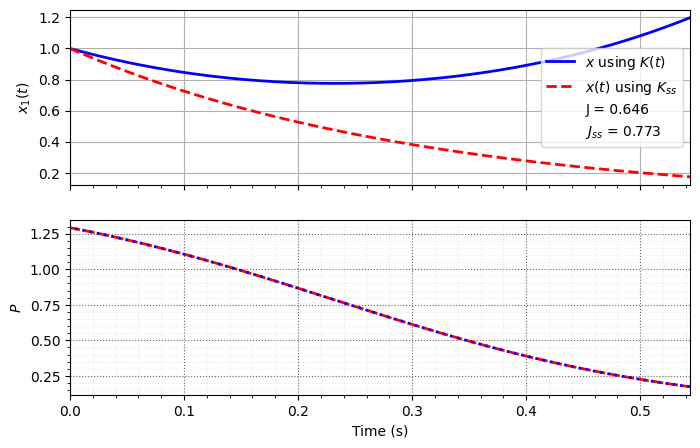

In [21]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8,5), sharex='col', sharey='row')

ax1.plot(t,X[0,:],'b-',label=r'$x$ using $K(t)$')
ax1.plot(t,X_ss[0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
ax1.set_ylabel(r'$x_1(t)$')
nicegrid()
ax1.set_xlim([0,Tf])
ax1.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
ax1.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(J_ss,3)))
ax1.legend(loc='best')

ax2.plot(t,P,'r--',label=r'$P(t) - analytic$')
ax2.plot(tau, sol[:, 0], 'b:', label=r'$P$ - numeric')
ax2.set_ylabel(r'$P$')
nicegrid()
ax2.set_xlim([0,Tf])
ax2.set_xlabel(r'Time (s)')
plt.savefig("figs/CLQR_ex17_12_3.png")
plt.show()